In [1]:
import pandas as pd
import numpy as np
import pickle
import ast
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

In [2]:
imdb_movies = pd.read_csv('Data/merged_data.csv', index_col=0)
imdb_movies.columns

Index(['budget', 'genres', 'homepage', 'id', 'keywords', 'original_language',
       'original_title', 'overview', 'popularity', 'production_companies',
       'production_countries', 'release_date', 'revenue', 'runtime',
       'spoken_languages', 'status', 'tagline', 'title', 'vote_average',
       'vote_count', 'ceremony_year', 'cast', 'crew', 'Oscars',
       'Nominations_Oscars', 'GoldenGlobes', 'Nominations_GoldenGlobes'],
      dtype='object')

In [3]:
def get_list(x):
    list_dict = ast.literal_eval(x)
    if(list_dict):
        list_ = []
        for d in list_dict:
            list_.append(d['name'].replace(' ',''))
        return list_
    else: 
        return []

def join_list(x):
    return ' '.join(x)

In [4]:
def get_similarity(column, dataset):
    '''Function for computing the adjacency matrices
    INPUTS: column: name of the column we want the adjacency matrix for
            dataset: imdb dataset containing the needed column (imdb_movies or imdb_credits)
    RETURN: csim: sclaed cosine similarity distance adjacency matrix'''
    
    # Make a temporary copy for computation
    data_copy = dataset.copy()
    
    # Modify column so we can compute similarity
    data_copy[column] = data_copy[column].apply(get_list)
    #items = sorted(data_copy.explode(column=column)[column].unique())
    data_copy[column] = data_copy[column].apply(join_list)
    
    # Vectorize and compute similarity
    vectorizer = TfidfVectorizer()
    vectors = vectorizer.fit_transform(data_copy[column]).toarray()
    csim = cosine_similarity(vectors)
    
    # Min-max scaling
    csim[np.diag_indices(csim.shape[0])] = 0
    csim = csim/csim.ptp()
    
    # transformation to DataFrame
    csim = pd.DataFrame(csim, index=data_copy['title'], columns=data_copy['title'])
    
    return csim

In [5]:
# Similarity matrices generation
csim_genre = get_similarity('genres', imdb_movies) # Movie genre (e.g Action, Drama...)
csim_keywords = get_similarity('keywords', imdb_movies) # Movie kewords
csim_cast = get_similarity('cast', imdb_movies) # Movie cast (actors)
csim_crew = get_similarity('crew', imdb_movies) # Movie cast (realisator, productor...)

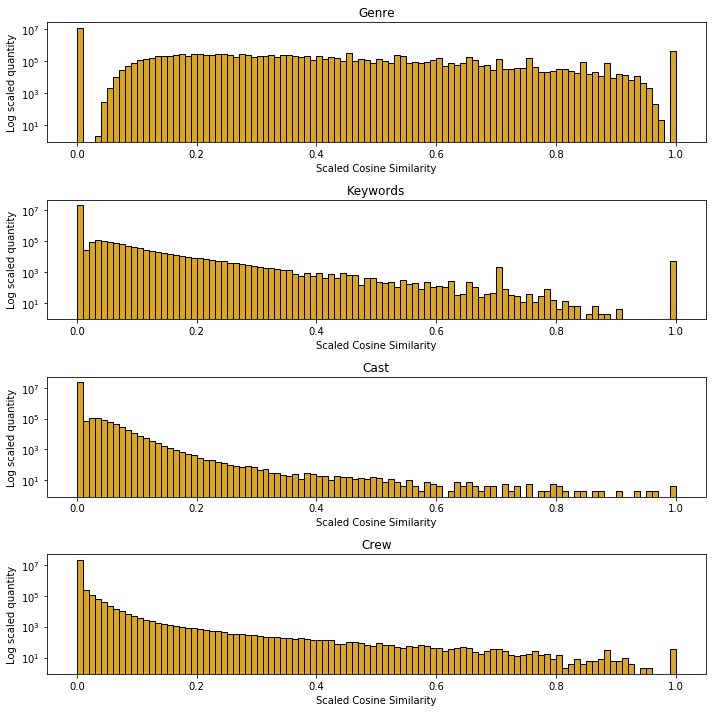

In [8]:
fig, axs = plt.subplots(4, 1,figsize=(10, 10))
titles = ['Genre', 'Keywords', 'Cast', 'Crew']
adj_mat = [csim_genre, csim_keywords, csim_cast, csim_crew]
for name, mat, ax in zip(titles, adj_mat, axs.reshape(-1)):
    ax.hist(mat.values.ravel(), log=True, bins=100, color='Goldenrod', linewidth=1, edgecolor='black')
    ax.set_title(name)
    ax.set_xlabel('Scaled Cosine Similarity')
    ax.set_ylabel('Log scaled quantity')
fig.tight_layout()
plt.show()

In [9]:
csim_genre.to_pickle('Data/csim_genre')
csim_keywords.to_pickle('Data/csim_keywords')
csim_cast.to_pickle('Data/csim_cast')
csim_crew.to_pickle('Data/csim_crew')

### Adjacency matrix 
combine 1/3 for all

In [10]:
A = np.zeros(csim_genre.shape)
for wi, adj in zip([1/3, 1/3, 1/3],  [csim_genre, csim_cast, csim_crew]):
     A += wi*adj.values
A = np.where(A < 0.32, 0, A)

In [11]:
with open('Data/Adjacency_matrix.pickle', 'wb') as handle:
    pickle.dump(A, handle, protocol=pickle.HIGHEST_PROTOCOL)
    print('Adjacency matrix saved at '+'Data/Adjacency_matrix.pickle')

Adjacency matrix saved at Data/Adjacency_matrix.pickle
